# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Compare relu variants
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [118]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [119]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

In [120]:
# Set 10 random sugar values to NaN
sugar_nan_indices = np.random.choice(np.arange(len(data)), size=10, replace=False)

corrupted_data = data.copy()
corrupted_data.loc[sugar_nan_indices, 'residual sugar'] = np.nan

In [121]:
# Split testing-training data (test has nan values)
test_mask = corrupted_data['residual sugar'].isnull()
train_data = corrupted_data[~test_mask].drop(columns='residual sugar')
test_data = corrupted_data[test_mask].drop(columns='residual sugar')

# Make sure the labels are a 1-N column vector
train_labels = np.vstack(data[~test_mask]['residual sugar'].values)
test_labels = np.vstack(data[test_mask]['residual sugar'].values)

# Convert data to tensors
train_dataT = torch.tensor(train_data.values).float()
test_dataT = torch.tensor(test_data.values).float()
train_labelsT = torch.tensor(train_labels).float()
test_labelsT = torch.tensor(test_labels).float()

# Then convert them into PyTorch Datasets
train_dataS = torch.utils.data.TensorDataset(train_dataT, train_labelsT)
test_dataS  = torch.utils.data.TensorDataset(test_dataT, test_labelsT)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_dataS, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataS, batch_size=test_dataS.tensors[0].shape[0])

# Now for the DL part

In [122]:
# create a class for the model

class ANNwine_suger_predictor(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )

    # Linear output!
    return self.output(x)

# Train the model

In [133]:
# a function that trains the model

# global parameter
numepochs = 100

def trainTheModel():

  # Create the ANN
  winenet = ANNwine_suger_predictor()

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(winenet.parameters(), lr=.001, weight_decay=0.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      y_combined = torch.cat((yHat, y), 1).T
      batchAcc.append( 100 * torch.corrcoef(y_combined)[0, 1].item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    y_combined = torch.cat((yHat, y), 1).T
    testAcc.append( 100 * torch.corrcoef(y_combined)[0, 1].item() )
  
  # function output
  return trainAcc,testAcc,losses,winenet

In [134]:
# Make sure the model 'works'
net = ANNwine_suger_predictor()
net(next(iter(train_loader))[0])

tensor([[0.1145],
        [0.0991],
        [0.0952],
        [0.0690],
        [0.0225],
        [0.0423],
        [0.0607],
        [0.1118],
        [0.0892],
        [0.1095],
        [0.1143],
        [0.0873],
        [0.1230],
        [0.1435],
        [0.0608],
        [0.0956]], grad_fn=<AddmmBackward0>)

In [135]:
# create a model and train it
trainAcc, testAcc, losses, winenet = trainTheModel()

In [136]:
# Get evaluation data
winenet.eval()

yHat_test = winenet(test_dataT)
yHat_train = winenet(train_dataT)

y_combined = torch.cat((yHat_test, test_labelsT), 1).T
test_corr = torch.corrcoef(y_combined)[0, 1].item()

y_combined = torch.cat((yHat_train, train_labelsT), 1).T
train_corr = torch.corrcoef(y_combined)[0, 1].item()

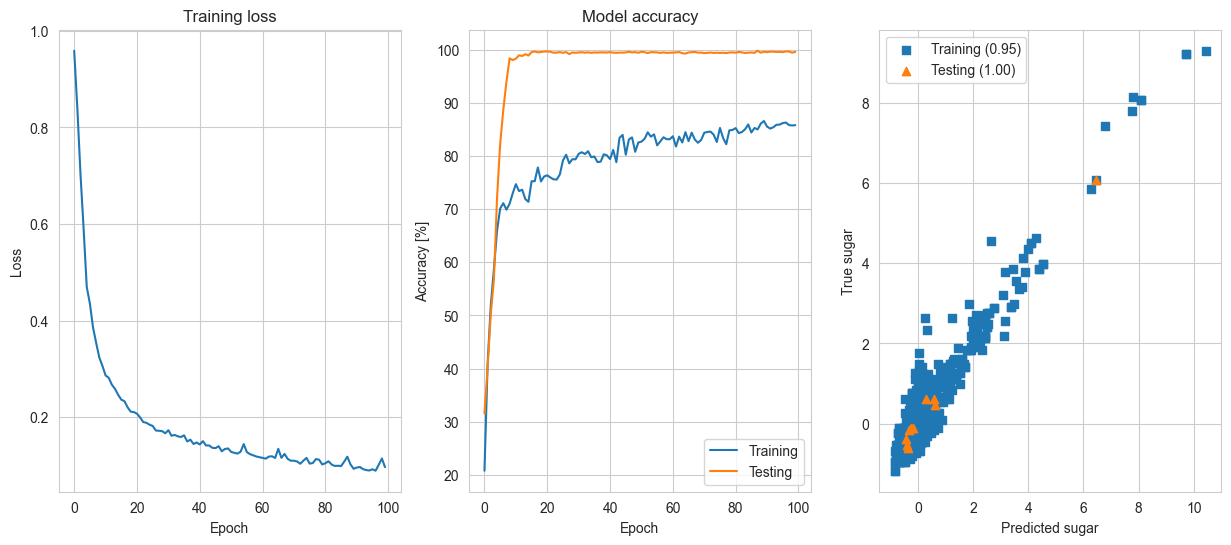

In [137]:
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")

plt.subplot(132)
plt.plot(trainAcc, label="Training")
plt.plot(testAcc, label="Testing")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.title("Model accuracy")

plt.subplot(133)
plt.xlabel("Predicted sugar")
plt.ylabel("True sugar")
plt.scatter(yHat_train.detach().numpy().flatten(), train_labels, label=f"Training ({train_corr:.2f})", marker='s')
plt.scatter(yHat_test.detach().numpy().flatten(), test_labels, label=f"Testing ({test_corr:.2f})", marker='^')
plt.legend()

plt.show()